- Compare KNN with random forest. 
- find data set
    - set # of trees to 100
    - choose k'(prime)
- graph MSE - y axis
    - # trees on x axis 


#### Notes about code below:
- uses model_selection import KFold
    - built in kfold library creates the folds, can easily reproduce the same folds and selection and iterate over
- remember for classification problems outcome is between 0 and 1
- for continuous regression, outcome is still a probability but on a continuous scale.
- for creating data, good choices are:
    - np.random.choice
    - np.random.rand
    - np.random.randint
    - np.random.normal
- To convert a dataframe to np array use df.as_matrix(), I selected the columns first then converted.
- remember sklearn works with np not pd.
- Once we reach a large enough forest of trees, MSE will not get better.
- When more trees are added, MSE will not go up, it will only go down or remain level.
- for convenience to iterate across all parameters use model_selection import GridSerchCV
    - scoring we will use neg_mean_squared_error.
       - converts to negative, because when plotting, the higher the number the better for visual effect
       - It's how sklearn handles mse and other scoring. 
- relative importance plot of feature importance.
- We can then relate features against support into a line plot across a single feature
    - Called a partial dependency plot
- we can then relate features together between them to uncover relationships
- sklearn.pipeline import Pipeline
    - standardize and transform data
    - allows iteration through multiple projects quickly
        - facilites easy exploration of tuning parameters
- When creating effect curve, use fit data
    - because want to know how it changes over prediction, aka effect of prediction.


    

    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('dataset/kc_house_data.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [2]:
# pd.get_dummies(df[['zipcode']], prefix='zip-')

In [83]:
# get a subset of the data and convert to np.
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'condition', 'sqft_lot', 'waterfront', 'view', 'zipcode']].as_matrix()
Y = df['price']


#convert the zip code to categorical data.

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# labelencoder_X = LabelEncoder()
x_copy = X.copy()
# X[:, 7] = labelencoder_X.fit_transform(X[:, 7])

#It was not required for me to first transform the label into a numeric value using labelencoder because 
# the zip codes are already numbers ready to transform into categories. 
# had the column been states or another non numeric type value, then, yes, first step is labelencoder.
onehotencoder = OneHotEncoder(categorical_features = [7])
X = onehotencoder.fit_transform(X).toarray()

#create a list of labels for use later in matching results to appropriate column.
label_list = onehotencoder.active_features_.tolist() + \
                            ['bedrooms', 'bathrooms', 'sqft_living', 'condition', \
                             'sqft_lot', 'waterfront', 'view']

# # Encoding the Dependent Variable
# labelencoder_y = LabelEncoder()
# Y = labelencoder_y.fit_transform(Y)

In [84]:
print(X.shape)
print(len(label_list))


(21613, 77)
78


In [23]:
print(X[0:3,4:70])
print(X[0:3,7:20])
print(X.shape)
print(X[0:3, -3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
(21613, 78)
[ 

In [148]:
print(set(X[:,7]))
print(labelencoder_X.classes_)
print(labelencoder_X.transform(x_copy[:,7]))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0}
[ 98001.  98002.  98003.  98004.  98005.  98006.  98007.  98008.  98010.
  98011.  98014.  98019.  98022.  98023.  98024.  98027.  98028.  98029.
  98030.  98031.  98032.  98033.  98034.  98038.  98039.  98040.  98042.
  98045.  98052.  98053.  98055.  98056.  98058.  98059.  98065.  98070.
  98072.  98074.  98075.  98077.  98092.  98102.  98103.  98105.  98106.
  98107.  98108.  98109.  98112.  98115.  98116.  98117.  98118.  98119.
  98122.  98125.  98126.  98133.  98136.  98144.  98146.  98148.  98155.
  98166.  98168.  98177.  98178.  98188.  98198.  98199.]
[66 55 16 ..., 59 15

In [21]:
onehotencoder = OneHotEncoder(categorical_features = [7])
tmp_x = onehotencoder.fit_transform(x_copy).toarray()
print(tmp_x.shape)
print(onehotencoder.active_features_)
print(type(onehotencoder.active_features_))
onehotencoder.active_features_.tolist()

(21613, 78)
[0 1]
<class 'numpy.ndarray'>


[0, 1]

In [53]:
# print(tmp_x[0:10,0:76])
# print(x_copy[0:10,7])
tmp_bool = tmp_x[0:10,0:70]==1
# print(tmp_bool)
# print([onehotencoder.active_features_[val] for val in tmp_bool])
onehotencoder.active_features_

array([0, 1])

20304850671.412113
33305304743.605988
24353837688.4894
30735154477.40158
22769068950.882645


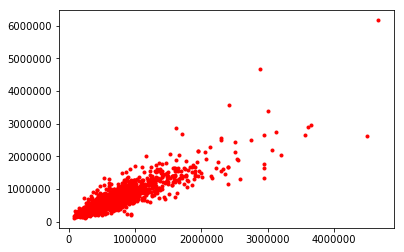

In [6]:
# create a randomforestRegressor object that will build a forest with n_estimators of trees
rf = RandomForestRegressor(n_estimators=50)

# Create the kfold split object with n_splits, shuffle=True to mix data, 
# and random_state = 0 us default numpy rng random number gen. 
kf = KFold(n_splits = 5, shuffle = True, random_state=0)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    rf.fit(X_train,y_train)
    print(np.mean((rf.predict(X_test)-y_test)**2))
    
plt.plot(y_test, rf.predict(X_test), 'r.')

In [7]:
ts = range(1,101,10)
MSEs=[]
K=5
kf = KFold(n_splits=K, random_state=0, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    tmp = []
    for t in ts:
        rf = RandomForestRegressor(n_estimators=t)
        rf.fit(X_train,y_train)
        tmp.append(np.mean((rf.predict(X_test)-y_test)**2))
    MSEs.append(tmp)

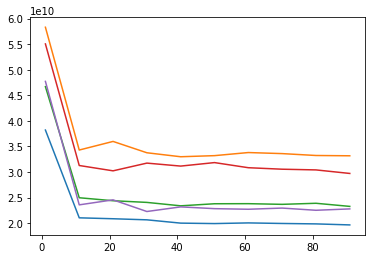

In [8]:
# more trees does not lead to overfitting
# but of course a model (e.g., a random forest CAN STILL overfit)
# ((just not because of adding more trees...))
plt.plot(ts,MSEs[0])
for k in range(1,K):
    plt.plot(ts,MSEs[k])

### Questions:  Look up pros and cons of GridSearchCV
- Since it is exhaustive, does it take longer than greedy search?
    - What about when features list grows? Exhaustive will take too long to execute.

In [33]:
### Using the GridSearchCV we can use the built in functionality of building the Cross Validation
## it allows a few lines that manages the processes for me. 

from sklearn.model_selection import GridSearchCV

# parameters = {'max_features': list(range(1,X.shape[1]+1))}
parameters = {'max_features': list(range(1,X.shape[1]+1,10))}
rf = RandomForestRegressor(n_estimators=40)
KK=5
models = GridSearchCV(estimator=rf, param_grid=parameters, cv=KK, scoring='neg_mean_squared_error')
models.fit(X, np.log(Y))

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 11, 21, 31, 41, 51, 61, 71]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [10]:
#models.best_params_
models.cv_results_

{'mean_fit_time': array([ 0.87289381,  0.9484746 ,  0.98226528,  1.00115595,  1.06383276,
         1.14867125,  1.21764274,  1.23922467,  1.32578878,  1.37482595,
         1.41155257,  1.56688251,  1.51493983,  1.62661939,  1.70087619,
         1.81914496,  1.79397182,  1.8494813 ,  1.86840177,  1.89731302,
         1.98308358,  2.10865183,  2.1906702 ,  2.20806656,  2.16302819,
         2.37244678,  2.39027128,  2.44849606,  2.58281121,  2.7791183 ,
         2.73775043,  2.83060756,  2.78493886,  2.90837102,  3.00449462,
         3.09251394,  3.05393634,  3.20986667,  3.27134714,  3.20750904,
         3.2741343 ,  3.32989597,  3.46471677,  3.47856913,  3.66354756,
         3.65613422,  3.70034389,  3.75197654,  3.83122911,  3.90756292,
         3.99563932,  4.10256443,  4.13014426,  4.16193547,  4.29143462,
         4.34604974,  4.39028182,  4.45795479,  4.53239646,  4.64112864,
         4.68802705,  4.75557194,  4.82050776,  5.00749764,  4.98745317,
         5.02549024,  5.11202817, 

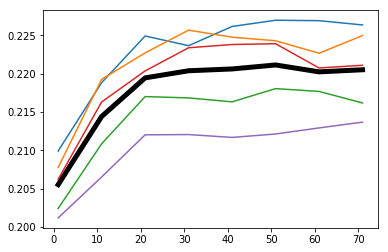

In [34]:
plt.plot(models.cv_results_['param_max_features'].data, np.sqrt(-1*models.cv_results_['mean_test_score']),linewidth=5,c='k')
for i in range(K):
    plt.plot(models.cv_results_['param_max_features'].data, np.sqrt(-1*models.cv_results_['split'+str(i)+'_test_score']))

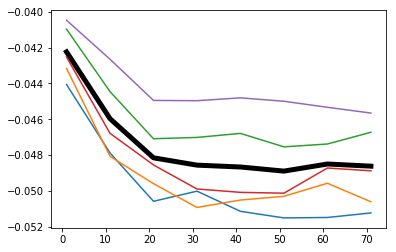

In [35]:
plt.plot(models.cv_results_['param_max_features'].data, models.cv_results_['mean_test_score'],linewidth=5,c='k')
for i in range(K):
    plt.plot(models.cv_results_['param_max_features'].data, models.cv_results_['split'+str(i)+'_test_score'])

(array([ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.]),
 <a list of 8 Text xticklabel objects>)

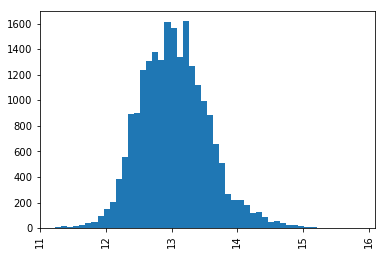

In [32]:
plt.hist(np.log(Y), bins=50)

plt.xticks(rotation=90)

In [39]:
np.sqrt(np.mean((Y - np.exp(models.best_estimator_.predict(X)))**2))


73073.873489639533

In [12]:
res = pd.DataFrame({"rank" : models.cv_results_['rank_test_score'],\
                    "k" : models.cv_results_['param_max_features'].data,\
                    "MSE" : -models.cv_results_['mean_test_score']})
res.sort_values(by="rank")

,MSE,k,rank
5,2.515808e+10,6,1
6,2.534064e+10,7,2
2,2.549159e+10,3,3
3,2.550169e+10,4,4
7,2.553196e+10,8,5
8,2.559098e+10,9,6
64,2.573542e+10,65,7
4,2.578077e+10,5,8
1,2.578402e+10,2,9
0,2.579475e+10,1,10


In [77]:
fig = plt.figure(figsize=(100,200))
s=np.argsort(models.best_estimator_.feature_importances_)
plt.barh(range(len(s)),width=models.best_estimator_.feature_importances_[s])
name_np_array = np.array(label_list)
plt.tick_params(labelsize=68)
tmp=plt.yticks(range(X.shape[1]),name_np_array[s])

In [73]:
print(len(models.best_estimator_.feature_importances_[s]))
print(X.shape[1])
print(len(label_list))

78
77
78


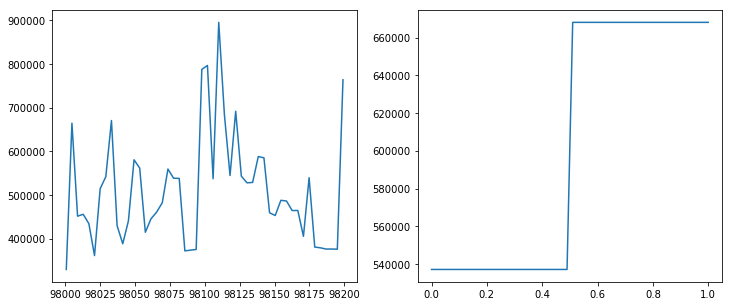

In [55]:
fig, axes = plt.subplots(1,2, figsize=[12,5])

support = np.linspace(min(X[:,-1]),max(X[:,-1]),25)
avg = []
for i in support:
    Xtmp = X.copy()
    Xtmp[:,-1] = i    
    avg.append(np.mean(models.best_estimator_.predict(Xtmp)))
    
axes[0].plot(support,avg)

support = np.linspace(min(X[:,5]),max(X[:,5]),25)
avg = []
for i in support:
    Xtmp = X.copy()
    Xtmp[:,5] = i    
    avg.append(np.mean(models.best_estimator_.predict(Xtmp)))
    
axes[1].plot(support,avg)

In [67]:
g = np.meshgrid(np.linspace(min(X[:,-1]),max(X[:,-1]),20),np.linspace(min(X[:,5]),max(X[:,5]),20))
z = 0*g[0]
for xi in range(20):
    for yi in range(20):
        Xtmp = X.copy()
        Xtmp[:,-1] = g[0][xi,yi]
        Xtmp[:,5] = g[1][xi,yi]
        z[xi,yi] = np.mean(models.best_estimator_.predict(Xtmp))

array([[  3.00000000e+00,   1.00000000e+00,   1.18000000e+03,
          3.00000000e+00,   5.65000000e+03]])

In [59]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(g[0], g[1], z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('LSTAT')
ax.set_ylabel('RM')

0        1180
1        2570
2         770
3        1960
4        1680
5        5420
6        1715
7        1060
8        1780
9        1890
10       3560
11       1160
12       1430
13       1370
14       1810
15       2950
16       1890
17       1600
18       1200
19       1250
20       1620
21       3050
22       2270
23       1070
24       2450
25       1710
26       2450
27       1400
28       1520
29       2570
         ... 
21583     710
21584    1260
21585    1870
21586    1430
21587    1520
21588    1210
21589    2540
21590    4910
21591    2770
21592    1190
21593    4170
21594    2500
21595    1530
21596    3600
21597    3410
21598    3118
21599    3990
21600    4470
21601    1425
21602    1500
21603    2270
21604    1490
21605    2520
21606    3510
21607    1310
21608    1530
21609    2310
21610    1020
21611    1600
21612    1020
Name: sqft_living, Length: 21613, dtype: int64